In [1]:
# Import necessary libraries and define the data loading function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [2]:
# Load data
def load_data(seq_length):
    """
    Load text data from 'dataset.txt' and generate training samples and labels based on the specified sequence length.
    Also constructs mappings between characters and their indices.
    """
    # Read text from file (ensure 'dataset.txt' is in the same directory)
    with open('dataset.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Create a sorted list of unique characters
    chars = sorted(list(set(text)))
    ix_to_char = {i: ch for i, ch in enumerate(chars)}
    char_to_ix = {ch: i for i, ch in enumerate(chars)}
    
    # Construct input sequences and corresponding next-character labels
    X, y = [], []
    for i in range(len(text) - seq_length):
        sequence = text[i:i+seq_length]
        label = text[i+seq_length]
        X.append([char_to_ix[char] for char in sequence])
        y.append(char_to_ix[label])
    
    X = np.array(X)
    y = np.array(y)
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.long)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    
    return X_train, y_train, X_val, y_val, char_to_ix, ix_to_char, len(chars)

# Example: load data with sequence length = 10
seq_length = 10
X_train, y_train, X_val, y_val, char_to_ix, ix_to_char, vocab_size = load_data(seq_length)
print(f"Data loaded successfully. Vocabulary size: {vocab_size}")

Data loaded successfully. Vocabulary size: 45


In [3]:
# Define three character-level models using nn.RNN, nn.LSTM, and nn.GRU

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])  # Use the output of the last time step
        return output

class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        return output

class CharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.fc(output[:, -1, :])
        return output

In [4]:
# Positional Encoding (from professor's sample code)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x shape: (batch, seq_length, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [5]:
# Define Transformer-based Model for Next Character Prediction
class CharTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward=256, dropout=0.1):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def forward(self, x):
        # x shape: (batch, seq_length)
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        # Use the output of the last time step for prediction
        x = self.fc(x[:, -1, :])
        return x

In [6]:
# Utility functions: Count parameters and training routine
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.005, device='cpu'):
    """
    Train the given model and record training loss, validation loss, and validation accuracy per epoch.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    start_time = time.time()
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        X_train_device = X_train.to(device)
        y_train_device = y_train.to(device)
        output = model(X_train_device)
        loss = criterion(output, y_train_device)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            X_val_device = X_val.to(device)
            y_val_device = y_val.to(device)
            val_output = model(X_val_device)
            val_loss = criterion(val_output, y_val_device)
            _, predicted = torch.max(val_output, 1)
            val_acc = (predicted == y_val_device).float().mean()
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f} Val Loss: {val_loss.item():.4f} Val Acc: {val_acc.item():.4f}')
    
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f}s")
    return training_time, train_losses, val_losses, val_accuracies

In [7]:
# Run experiments for different sequence lengths and model types
seq_lengths = [10, 20, 30]
model_names = ['Transformer', 'RNN', 'LSTM', 'GRU']
model_classes = {
    'Transformer': CharTransformer,
    'RNN': CharRNN,
    'LSTM': CharLSTM,
    'GRU': CharGRU
}
results = []

# Hyperparameters
hidden_size = 128   # for RNN-based models
d_model = 128       # for Transformer model
nhead = 4           # number of attention heads
num_layers = 2      # number of layers
epochs = 50
learning_rate = 0.005
device = 'cpu'      # change to 'cuda' if GPU is available

for seq_length in seq_lengths:
    print(f"\nSequence Length: {seq_length}")
    X_train, y_train, X_val, y_val, char_to_ix, ix_to_char, vocab_size = load_data(seq_length)
    for model_name in model_names:
        if model_name == 'Transformer':
            model = model_classes[model_name](vocab_size, d_model, nhead, num_layers)
        else:
            model = model_classes[model_name](vocab_size, hidden_size, vocab_size)
        param_count = count_parameters(model)
        print(f"Training {model_name} with sequence length {seq_length} | Parameters: {param_count}")
        training_time, train_losses, val_losses, val_accuracies = train_model(model, X_train, y_train, X_val, y_val, epochs, learning_rate, device)
        results.append({
            'model': model_name,
            'seq_length': seq_length,
            'training_time': training_time,
            'param_count': param_count,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        })


Sequence Length: 10
Training Transformer with sequence length 10 | Parameters: 276525
Epoch 10/50 Loss: 2.2761 Val Loss: 2.4343 Val Acc: 0.3040
Epoch 20/50 Loss: 1.9753 Val Loss: 2.4256 Val Acc: 0.3208
Epoch 30/50 Loss: 1.6639 Val Loss: 2.4241 Val Acc: 0.3543
Epoch 40/50 Loss: 1.4566 Val Loss: 2.5600 Val Acc: 0.3438
Epoch 50/50 Loss: 1.1872 Val Loss: 2.6776 Val Acc: 0.3648
Training time: 3.64s
Training RNN with sequence length 10 | Parameters: 44589
Epoch 10/50 Loss: 2.2677 Val Loss: 2.3233 Val Acc: 0.3920
Epoch 20/50 Loss: 1.8088 Val Loss: 2.1175 Val Acc: 0.4382
Epoch 30/50 Loss: 1.4458 Val Loss: 2.0060 Val Acc: 0.4528
Epoch 40/50 Loss: 1.1251 Val Loss: 1.9705 Val Acc: 0.4738
Epoch 50/50 Loss: 0.8275 Val Loss: 1.9856 Val Acc: 0.4990
Training time: 0.69s
Training LSTM with sequence length 10 | Parameters: 143661
Epoch 10/50 Loss: 2.5506 Val Loss: 2.4972 Val Acc: 0.3019
Epoch 20/50 Loss: 2.0337 Val Loss: 2.1821 Val Acc: 0.3920
Epoch 30/50 Loss: 1.6283 Val Loss: 1.9939 Val Acc: 0.4591
E

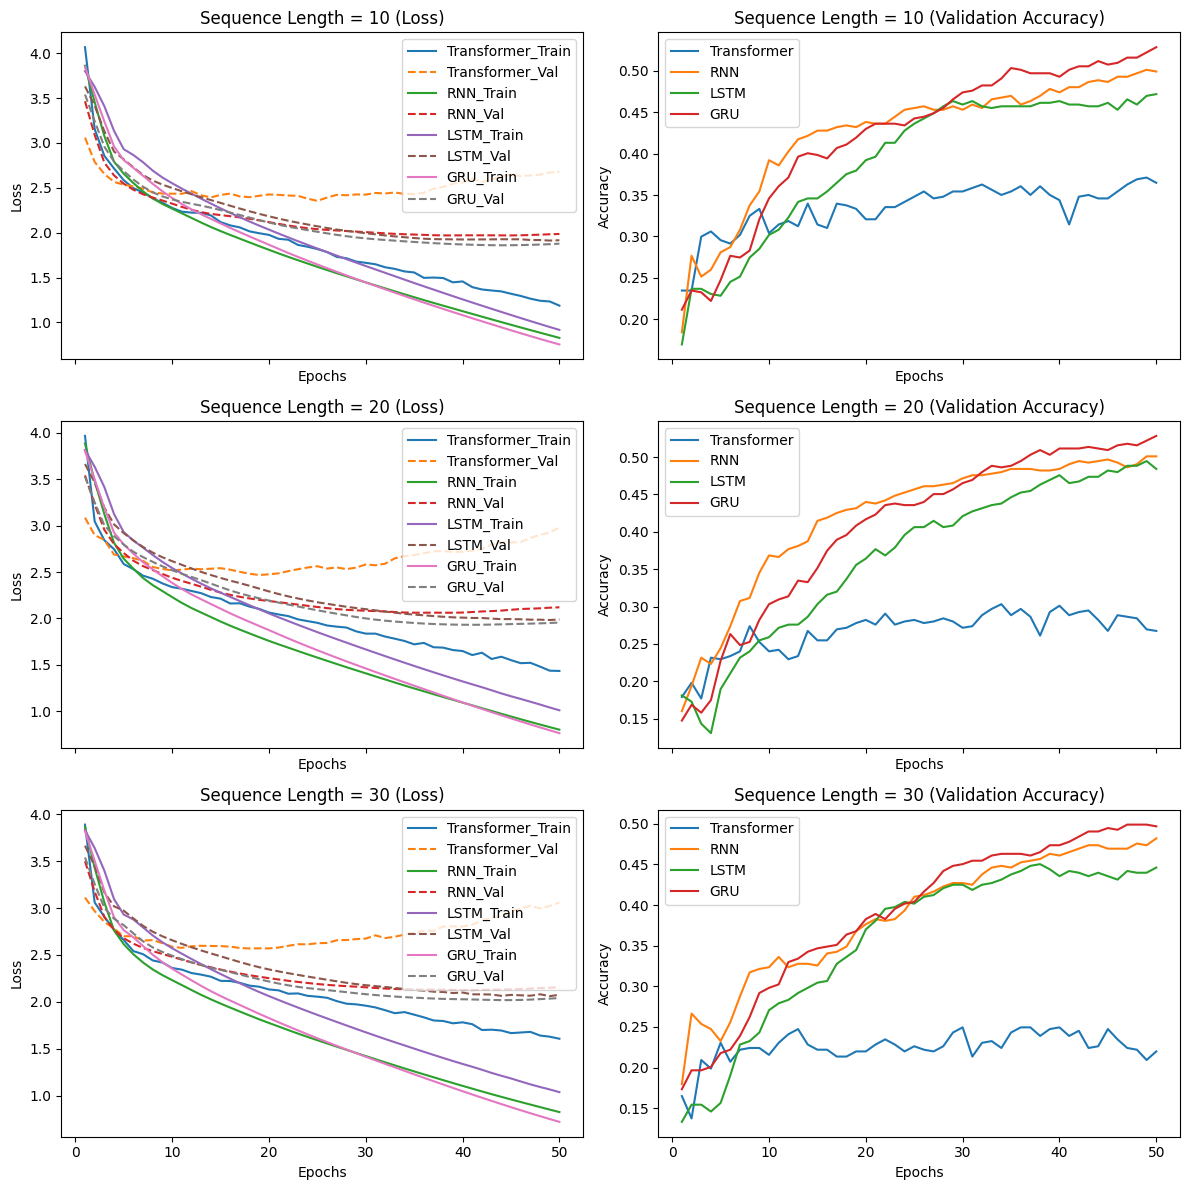

In [8]:
# Plot the training loss and validation accuracy curves for each experiment.
# Create a 3x2 grid: each row corresponds to a sequence length,
# left column for loss and right column for validation accuracy.

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharex=True)

for i, seq_length in enumerate(seq_lengths):
    ax_loss = axes[i, 0]
    ax_acc = axes[i, 1]
    for result in results:
        if result['seq_length'] == seq_length:
            epochs_range = range(1, epochs + 1)
            # Plot training and validation loss curves on the same subplot
            ax_loss.plot(epochs_range, result['train_losses'], label=f"{result['model']}_Train")
            ax_loss.plot(epochs_range, result['val_losses'], linestyle='--', label=f"{result['model']}_Val")
            # Plot validation accuracy
            ax_acc.plot(epochs_range, result['val_accuracies'], label=result['model'])
    
    ax_loss.set_title(f"Sequence Length = {seq_length} (Loss)")
    ax_loss.set_xlabel("Epochs")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    
    ax_acc.set_title(f"Sequence Length = {seq_length} (Validation Accuracy)")
    ax_acc.set_xlabel("Epochs")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.legend()

plt.tight_layout()
plt.savefig("images/hw5_p1_result.png")
plt.show()

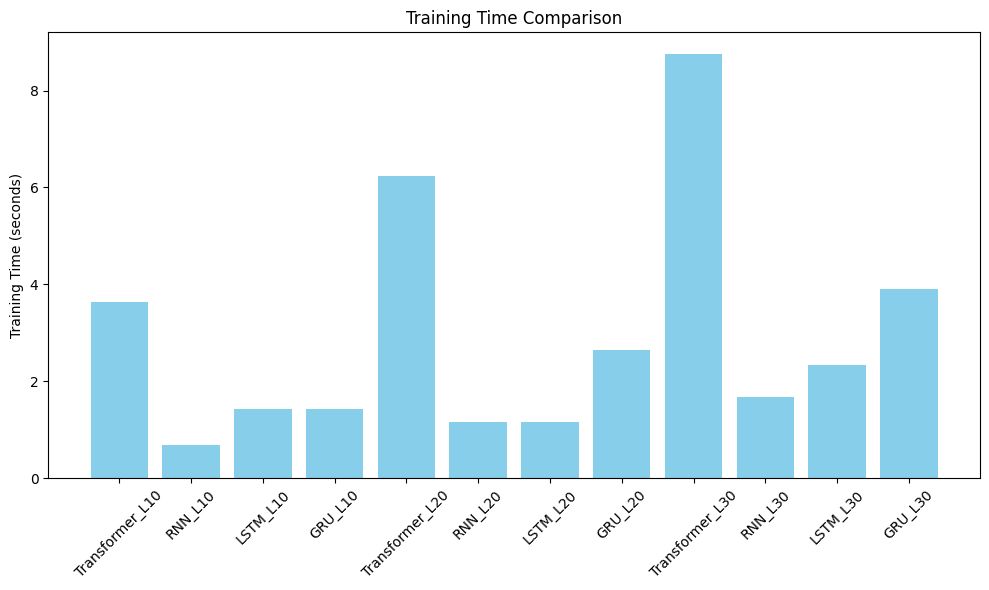

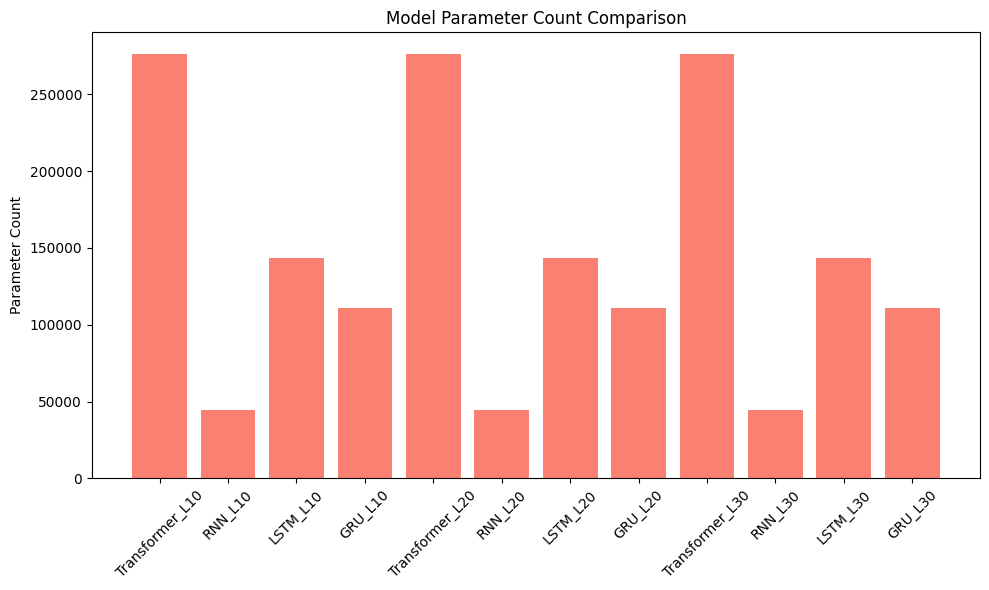

In [9]:
# Create bar charts to compare training time and model parameter counts across experiments.
# Prepare data for bar plots
labels = []
training_times = []
param_counts = []
for result in results:
    label = f"{result['model']}_L{result['seq_length']}"
    labels.append(label)
    training_times.append(result['training_time'])
    param_counts.append(result['param_count'])

# Plot training time comparison
plt.figure(figsize=(10, 6))
plt.bar(labels, training_times, color='skyblue')
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/hw5_p1_training_time_comparison.png")
plt.show()

# Plot parameter count comparison
plt.figure(figsize=(10, 6))
plt.bar(labels, param_counts, color='salmon')
plt.ylabel("Parameter Count")
plt.title("Model Parameter Count Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/hw5_p1_model_param_comparison.png")
plt.show()